# Named Entity Recognition using Bidirectional LSTMs and ELMo Embeddings

## Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install seqeval

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedShuffleSplit, KFold
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, add, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Layer

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

## EDA & Preprocessing

In [4]:
plt.style.use("ggplot")

data = pd.read_csv("/content/drive/MyDrive/ner_dataset.csv", encoding="ISO-8859-1")
data = data.fillna(method="ffill")
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
def contains_non_ascii(word):
    return any(ord(char) > 127 for char in word)

mask = data['Word'].apply(contains_non_ascii)
non_ascii_df = data[mask]
non_ascii_df.count()

Sentence #    53
Word          53
POS           53
Tag           53
dtype: int64

In [6]:
data = data[~mask]

In [7]:
data['Tag'].value_counts()

Tag
O        887875
B-geo     37641
B-tim     20333
B-org     20142
I-per     17244
B-per     16987
I-org     16782
B-gpe     15870
I-geo      7413
I-tim      6527
B-art       402
B-eve       308
I-art       295
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

In [8]:
data['POS'].value_counts()

POS
NN      145803
NNP     131410
IN      120996
DT       98454
JJ       78412
NNS      75835
.        47831
VBD      39379
,        32754
VBN      32328
VBZ      24957
CD       24695
VB       24211
CC       23716
TO       23061
RB       20252
VBG      19125
VBP      16158
PRP      13318
POS      11253
PRP$      8655
MD        6973
``        3720
WDT       3698
JJS       3034
JJR       2967
WP        2542
NNPS      2521
RP        2490
WRB       2184
$         1149
RBR       1055
:          793
RRB        679
LRB        678
EX         663
RBS        296
;          206
PDT        147
WP$         99
UH          24
FW           1
Name: count, dtype: int64

In [9]:
data['Sentence #'].value_counts()

Sentence #
Sentence: 22480    104
Sentence: 33481     81
Sentence: 40153     73
Sentence: 21167     72
Sentence: 21776     70
                  ... 
Sentence: 39874      2
Sentence: 37093      2
Sentence: 1595       2
Sentence: 8412       1
Sentence: 38917      1
Name: count, Length: 47959, dtype: int64

In [10]:
words = set(list(data['Word'].values))
words.add('PADword')
n_words = len(words)
n_words

35149

In [11]:
tags = list(set(data["Tag"].values))
n_tags = len(tags)
pos = list(set(data["POS"].values))
n_pos = len(pos)

n_tags, n_pos

(17, 42)

In [12]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [13]:
getter = SentenceGetter(data)
sent = getter.get_next()
for i in sent:
  print(i)

('Thousands', 'O')
('of', 'O')
('demonstrators', 'O')
('have', 'O')
('marched', 'O')
('through', 'O')
('London', 'B-geo')
('to', 'O')
('protest', 'O')
('the', 'O')
('war', 'O')
('in', 'O')
('Iraq', 'B-geo')
('and', 'O')
('demand', 'O')
('the', 'O')
('withdrawal', 'O')
('of', 'O')
('British', 'B-gpe')
('troops', 'O')
('from', 'O')
('that', 'O')
('country', 'O')
('.', 'O')


In [14]:
print(getter.sentences[1])

[('Iranian', 'B-gpe'), ('officials', 'O'), ('say', 'O'), ('they', 'O'), ('expect', 'O'), ('to', 'O'), ('get', 'O'), ('access', 'O'), ('to', 'O'), ('sealed', 'O'), ('sensitive', 'O'), ('parts', 'O'), ('of', 'O'), ('the', 'O'), ('plant', 'O'), ('Wednesday', 'B-tim'), (',', 'O'), ('after', 'O'), ('an', 'O'), ('IAEA', 'B-org'), ('surveillance', 'O'), ('system', 'O'), ('begins', 'O'), ('functioning', 'O'), ('.', 'O')]


In [15]:
print(max([len(s) for s in getter.sentences]))

104


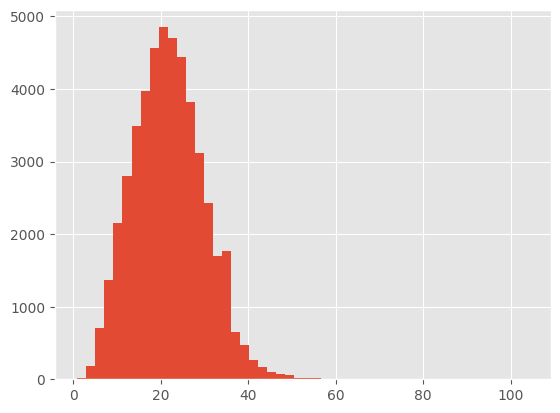

In [16]:
%matplotlib inline
plt.hist([len(sen) for sen in getter.sentences], bins= 50)
plt.show()

In [17]:
words2index = {w:i for i,w in enumerate(words)}
tags2index = {t:i for i,t in enumerate(tags)}
print(words2index['London'])
print(tags2index['B-geo'])

10981
16


In [18]:
data['Word_idx'] = data['Word'].map(words2index)
data['Tag_idx'] = data['Tag'].map(tags2index)
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,27174,15
1,Sentence: 1,of,IN,O,30304,15
2,Sentence: 1,demonstrators,NNS,O,12464,15
3,Sentence: 1,have,VBP,O,13567,15
4,Sentence: 1,marched,VBN,O,18162,15


In [19]:
data_group = data.groupby(
['Sentence #'],as_index=False
)[['Word', 'Tag', 'Word_idx', 'Tag_idx']].agg(lambda x: list(x))

data_group = data_group.sample(frac=0.5)

data_group.head()

,Sentence #,Word,Tag,Word_idx,Tag_idx
43112,Sentence: 5636,"[Farmers, in, Bangladesh, have, been, in, the,...","[O, O, B-geo, O, O, O, O, O, O, O, O, O]","[20336, 17305, 16451, 13567, 2192, 17305, 3103...","[15, 15, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15]"
17374,Sentence: 25635,"[Kyrgyzstan, became, a, Soviet, republic, in, ...","[B-gpe, O, O, O, O, O, B-tim, O, O, O, O, B-ti...","[2077, 17727, 25797, 26340, 32533, 17305, 1813...","[0, 15, 15, 15, 15, 15, 3, 15, 15, 15, 15, 3, ..."
10140,Sentence: 19124,"[A, report, from, the, International, Energy, ...","[O, O, O, O, B-org, I-org, I-org, O, B-org, O,...","[15901, 27033, 30530, 31038, 21280, 32079, 117...","[15, 15, 15, 15, 9, 1, 1, 15, 9, 15, 3, 15, 15..."
30764,Sentence: 37687,"[In, the, medium, term, ,, prospects, for, the...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[11529, 31038, 7075, 26701, 26414, 4245, 6630,...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1..."
16278,Sentence: 24649,"[Since, 2004, ,, they, have, slowly, been, all...","[O, B-tim, O, O, O, O, O, O, O, O, O]","[31637, 17116, 26414, 7743, 13567, 26369, 2192...","[15, 3, 15, 15, 15, 15, 15, 15, 15, 15, 15]"


In [20]:
max_len = 50
X = [[w[0] for w in s] for s in getter.sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("PADword")
    new_X.append(new_seq)

new_X = np.array(new_X)

X_tr_val = new_X[:int(0.4*len(new_X))]
X_final = new_X[int(0.4*len(new_X)):int(0.8*len(new_X))]
X_te = new_X[int(0.8*len(new_X)):]

In [21]:
y = [[tags2index[w[1]] for w in s] for s in getter.sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tags2index["O"])

y_tr_val = y[:int(0.4*len(y))]
y_final = y[int(0.4*len(y)):int(0.8*len(y))]
y_te = y[int(0.8*len(y)):]

## Cross Validation Implementation

In [22]:
n_splits = 5  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1789)

## Building Model

In [23]:
batch_size = 32

In [24]:
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)
        self.elmo_model = hub.load("https://tfhub.dev/google/elmo/3")
        self.output_dim = 1024

    def call(self, inputs):
        # Convert inputs to numpy array and then to the required type
        result = tf.py_function(self.elmo_embed, [inputs], tf.float32)
        result.set_shape((None, inputs.shape[1], self.output_dim))
        return result

    def elmo_embed(self, inputs):
        inputs = inputs.numpy().astype(str)
        embeddings = self.elmo_model.signatures['tokens'](
            tokens=tf.convert_to_tensor(inputs, dtype=tf.string),
            sequence_len=tf.convert_to_tensor([inputs.shape[1]] * inputs.shape[0], dtype=tf.int32)
        )['elmo']
        return embeddings

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.output_dim)

In [25]:
# Input layer
input_text = Input(shape=(max_len,), dtype=tf.string, name='input_text')

# Custom ELMo embedding layer
embedding = ElmoEmbeddingLayer()(input_text)

# First bidirectional LSTM layer with dropout
x = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(embedding)

# Second bidirectional LSTM layer with dropout
x_rnn = Bidirectional(LSTM(units=512, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))(x)

# Residual connection to the first bidirectional LSTM layer
x = add([x, x_rnn])

# TimeDistributed Dense layer for output
out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)

In [26]:
tag_model = Model(input_text, out)
tag_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [27]:
tag_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_text (InputLayer)     [(None, 50)]                 0         []                            
                                                                                                  
 elmo_embedding_layer (Elmo  (None, 50, 1024)             0         ['input_text[0][0]']          
 EmbeddingLayer)                                                                                  
                                                                                                  
 bidirectional (Bidirection  (None, 50, 1024)             6295552   ['elmo_embedding_layer[0][0]']
 al)                                                                                              
                                                                                              

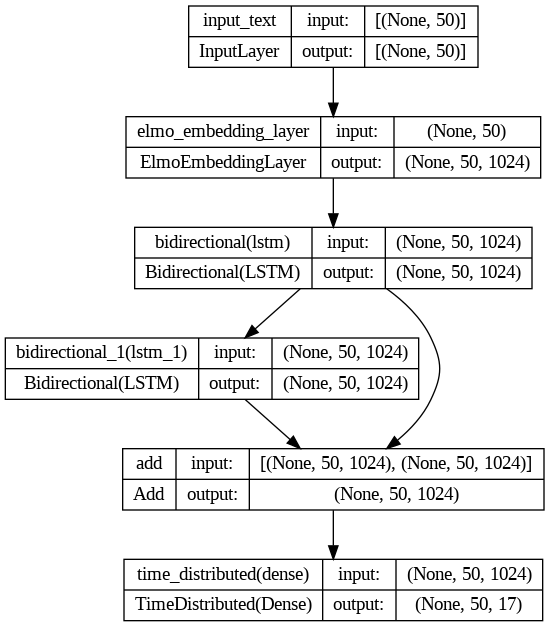

In [28]:
plot_model(tag_model,'Elmo_pos.png',show_shapes= True)

## Model Training

In [29]:
# Loop over each fold
fold_no = 1
for train_index, val_index in kf.split(X_tr_val):
    print(f"Training fold {fold_no}...")

    X_tr, X_val = X_tr_val[train_index], X_tr_val[val_index]
    y_tr, y_val = y_tr_val[train_index], y_tr_val[val_index]

    # Define and compile the model (re-initialize for each fold)
    tag_model = Model(input_text, out)
    tag_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    history = tag_model.fit(np.array(X_tr), y_tr, validation_data=(np.array(X_val), y_val),
                            batch_size=batch_size, epochs=1, verbose=1)

    print(f"Completed fold {fold_no}")
    fold_no += 1

Training fold 1...
480/480 [==============================] - 495s 987ms/step - loss: 0.0834 - accuracy: 0.9771 - val_loss: 0.0553 - val_accuracy: 0.9836
Completed fold 1
Training fold 2...
480/480 [==============================] - 485s 985ms/step - loss: 0.0505 - accuracy: 0.9846 - val_loss: 0.0445 - val_accuracy: 0.9862
Completed fold 2
Training fold 3...
480/480 [==============================] - 489s 994ms/step - loss: 0.0403 - accuracy: 0.9872 - val_loss: 0.0382 - val_accuracy: 0.9873
Completed fold 3
Training fold 4...
480/480 [==============================] - 470s 953ms/step - loss: 0.0330 - accuracy: 0.9889 - val_loss: 0.0268 - val_accuracy: 0.9907
Completed fold 4
Training fold 5...
480/480 [==============================] - 484s 984ms/step - loss: 0.0252 - accuracy: 0.9914 - val_loss: 0.0237 - val_accuracy: 0.9915
Completed fold 5


In [30]:
# Define and compile the final model
final_model = Model(input_text, out)
final_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the final model on the entire training dataset
final_model.fit(X_final, y_final, batch_size=batch_size, epochs=1, verbose=1)

600/600 [==============================] - 547s 891ms/step - loss: 0.0434 - accuracy: 0.9862


## Model Evaluation

In [31]:
test_pred = final_model.predict(X_te, verbose=1)

300/300 [==============================] - 90s 298ms/step


In [32]:
idx2tag = {i: w for w, i in tags2index.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out

pred_labels = pred2label(test_pred)
test_labels = test2label(y_te)

In [33]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels, average="weighted")))

F1-score: 81.7%


In [34]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

         art       0.12      0.13      0.13        83
         eve       0.34      0.24      0.28        68
         geo       0.85      0.86      0.85      7479
         gpe       0.95      0.93      0.94      3377
         nat       0.43      0.26      0.32        39
         org       0.66      0.68      0.67      4017
         per       0.74      0.79      0.77      3320
         tim       0.86      0.86      0.86      4082

   micro avg       0.81      0.82      0.82     22465
   macro avg       0.62      0.59      0.60     22465
weighted avg       0.81      0.82      0.82     22465



In [35]:
i = 395
p = tag_model.predict(np.array(X_te[i:i+batch_size]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:5}: ({})".format("Word", "Pred", "True"))
print("="*30)
for w, true, pred in zip(X_te[i], y_te[i], p):
    if w != "PADword":
        print("{:15}:{:5} ({})".format(w, tags[pred], tags[true]))

1/1 [==============================] - 2s 2s/step
Word            Pred : (True)
The            :O     (O)
United         :B-org (B-geo)
States         :I-geo (I-geo)
also           :O     (O)
alleges        :O     (O)
Syria          :B-geo (B-geo)
allows         :O     (O)
foreign        :O     (O)
fighters       :O     (O)
to             :O     (O)
travel         :O     (O)
into           :O     (O)
Iraq           :B-geo (B-geo)
.              :O     (O)
